In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Pipeline: chaininig estimator
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Data imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

# Feature Selection/Dimensionality Reduction

# Feature normalisation
from sklearn.preprocessing import StandardScaler

# Train test split
from sklearn.model_selection import train_test_split

# Model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#### Load the dataset

In [2]:
all_df = pd.read_excel("./Dataset/trainDataset.xls", sheet_name="Sheet1")
all_df = all_df.drop([218, 253, 285])
dataset_ID = all_df['ID']
all_df.drop('ID', axis=1, inplace=True)

#### Data imputation

In [3]:
missing_values_index = np.where(all_df.isin([999]) == True)
missing_values_index = np.array(missing_values_index)

new_df = all_df.replace(999, np.NaN)
column_names = new_df.columns

k_imp = KNNImputer()
k_imputed_array = k_imp.fit_transform(new_df)

multivariate_imp = IterativeImputer(random_state=42)
multi_imputed_array = multivariate_imp.fit_transform(new_df)

# loop through all the missing values rows and columns and impute the data with round up function
for i in range(len(missing_values_index[0])):
    row = missing_values_index[0][i]
    col = missing_values_index[1][i]
    k_imputed_array[row][col] = np.round(k_imputed_array[row][col])
    multi_imputed_array[row][col] = np.round(multi_imputed_array[row][col])
    print(k_imputed_array[row][col], multi_imputed_array[row][col])

# convert to dataFrame
k_imputed_df = pd.DataFrame(k_imputed_array, columns=column_names)
multi_imputed_df = pd.DataFrame(multi_imputed_array, columns=column_names)

# write imputed dataframe into excel sheet
k_imputed_df.to_excel('./knnImputedDataset.xlsx', sheet_name='Sheet 1', index=False)
multi_imputed_df.to_excel('./multivariateImputedDataset.xlsx', sheet_name='Sheet 1', index=False)

0.0 0.0
3.0 3.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0


#### Split the feature and target values

In [4]:
# Split the features and target values
X = multi_imputed_df.iloc[:, 2:]

# Target values: pCR (outcome)
classification_target = multi_imputed_df.iloc[:, :1]

#### Split the clinical feature and image feature

In [5]:
# Stores the clinical features
X_clinical = X.iloc[:,:10]

# Stores the image features
X_image = X.iloc[:,10:]

### Select K-Best using chi2 on clinical features

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

clinical_features = SelectKBest(chi2, k=10).fit(X_clinical, classification_target)

clinical_features_list = list(clinical_features.get_feature_names_out())
print(clinical_features_list)

['Age', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade', 'Proliferation', 'HistologyType', 'LNStatus', 'TumourStage']


In [7]:
Xn_clinical = X_clinical[clinical_features_list]

### Random Forest Classification on image features

#### 1. RF: Feature Selection Hyperparameter Tuning

In [8]:
from sklearn.model_selection import GridSearchCV

# rf_pre = RandomForestClassifier()

# param_grid = { 
#     'random_state': [42],
#     'class_weight': ['balanced'],
#     'n_estimators': np.arange(100,400,100).tolist(),
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [3,5,7,9],
#     'criterion' :['gini', 'entropy']
# }      
                           
# CV_rfc = GridSearchCV(estimator=rf_pre, param_grid=param_grid, cv= 5, verbose=3)
# CV_rfc.fit(X_image, classification_target)
# print(CV_rfc.best_params_)

#### 2. RF: Model Initialisation using the hyperparameter

In [9]:
# {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 300}
# rf = RandomForestClassifier(**CV_rfc.best_params_)
rf = RandomForestClassifier(random_state=42, class_weight='balanced', criterion='gini', max_depth=9, max_features='auto', n_estimators=300)
rf.fit(X_image, classification_target)

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=300,
                       random_state=42)

#### 3. Construct the N-Best image-based feature from RF feature selection

In [10]:
# Figure size settings
plt.rcParams.update({'figure.figsize': (100.0, 100.0)})
plt.rcParams.update({'font.size': 50})

In [11]:
# Sort the features
sorted_idx = rf.feature_importances_.argsort()
# Choose number of features to be displayed
num_select_features = 20
sorted_idx = sorted_idx[:num_select_features]

# Display the plot
plt.barh(X_image.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Text(0.5, 0, 'Random Forest Feature Importance')

#### 4. Assign the image feature

In [12]:
# Assigned selected feature
Xn_image_rf = X_image.iloc[:, sorted_idx]
print(Xn_image_rf.columns)

Index(['original_glcm_Contrast', 'original_glcm_Idn', 'original_glcm_Idmn',
       'original_glcm_Autocorrelation', 'original_glcm_Id',
       'original_glcm_DifferenceAverage', 'original_ngtdm_Contrast',
       'original_glcm_InverseVariance', 'original_glcm_JointEnergy',
       'original_glcm_SumAverage', 'original_glcm_ClusterTendency',
       'original_glcm_JointAverage', 'original_ngtdm_Complexity',
       'original_firstorder_Entropy', 'original_glcm_SumEntropy',
       'original_glcm_DifferenceVariance', 'original_glcm_MaximumProbability',
       'original_glcm_JointEntropy', 'original_glcm_SumSquares',
       'original_glcm_DifferenceEntropy'],
      dtype='object')


### PCA Dimensionality Reduction on Image-based Features

In [13]:
# from sklearn.decomposition import PCA

# feature_names = list(Xn_image.columns)
# pca = PCA(n_components=2)
# Xns_pca = pca.fit_transform(Xn_image)

In [14]:
# # Extract and retain the first two modes of PCA as new features

# PCA_df = pd.DataFrame()
# PCA_df['PCA_1'] = Xns_pca[:,0]
# PCA_df['PCA_2'] = Xns_pca[:,1]

In [15]:
# plt.rcParams.update({'figure.figsize': (100.0, 100.0)})
# plt.rcParams.update({'font.size': 10})

# plt.figure(figsize=(6,6))
# plt.plot(PCA_df['PCA_1'][multi_imputed_df['pCR (outcome)'] ==
# 0],PCA_df['PCA_2'][multi_imputed_df['pCR (outcome)'] == 0],'ro', alpha = 0.7, markeredgecolor = 'k')
# plt.plot(PCA_df['PCA_1'][multi_imputed_df['pCR (outcome)'] ==
# 1],PCA_df['PCA_2'][multi_imputed_df['pCR (outcome)'] == 1],'bo', alpha = 0.7, markeredgecolor = 'k')
# plt.xlabel('PCA_1')
# plt.ylabel('PCA_2')
# plt.legend(['Failed','Shrink'])

In [16]:
from sklearn.feature_selection import f_classif
image_features = SelectKBest(f_classif, k=20).fit(X_image, classification_target)

image_features_list = list(image_features.get_feature_names_out())

Xn_image_fc = X_image[image_features_list]
print(Xn_image_fc.columns)

Index(['original_firstorder_10Percentile', 'original_firstorder_Entropy',
       'original_firstorder_Median', 'original_glcm_Contrast',
       'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy',
       'original_glcm_DifferenceVariance', 'original_glcm_Id',
       'original_glcm_Idm', 'original_glcm_Idmn', 'original_glcm_Idn',
       'original_glcm_InverseVariance', 'original_gldm_DependenceEntropy',
       'original_gldm_LargeDependenceEmphasis',
       'original_glrlm_LongRunEmphasis',
       'original_glrlm_LongRunHighGrayLevelEmphasis',
       'original_glrlm_RunEntropy',
       'original_glrlm_RunLengthNonUniformityNormalized',
       'original_glrlm_RunPercentage', 'original_ngtdm_Complexity'],
      dtype='object')


In [17]:
Xn_select1 = set()
Xn_select2 = set()
Xn_select1.update(Xn_image_rf.columns)
Xn_select2.update(image_features_list)

Xn_select_final = Xn_select1.intersection(Xn_select2)
Xn_image = X_image[Xn_select_final]
print(Xn_select_final)

{'original_glcm_Id', 'original_firstorder_Entropy', 'original_glcm_Idn', 'original_glcm_InverseVariance', 'original_glcm_DifferenceEntropy', 'original_ngtdm_Complexity', 'original_glcm_Contrast', 'original_glcm_Idmn', 'original_glcm_DifferenceVariance', 'original_glcm_DifferenceAverage'}


#### Concatenate the selected clinical and image-based features

In [18]:
Xn = pd.concat([Xn_clinical, Xn_image], axis=1, join='inner')
# Xn = pd.concat([Xn_clinical, PCA_df], axis=1, join='inner')
print(Xn.columns)

Index(['Age', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade',
       'Proliferation', 'HistologyType', 'LNStatus', 'TumourStage',
       'original_glcm_Id', 'original_firstorder_Entropy', 'original_glcm_Idn',
       'original_glcm_InverseVariance', 'original_glcm_DifferenceEntropy',
       'original_ngtdm_Complexity', 'original_glcm_Contrast',
       'original_glcm_Idmn', 'original_glcm_DifferenceVariance',
       'original_glcm_DifferenceAverage'],
      dtype='object')


#### Train test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(Xn, 
                                                    classification_target,
                                                    stratify=classification_target,
                                                    test_size=0.3, 
                                                    random_state=42)


### Pipeline

In [20]:
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train)
Xs_test = scaler.fit_transform(X_test)

In [28]:
from sklearn.model_selection import GridSearchCV 

# Random Forest Classification
rf_clf = RandomForestClassifier(random_state=42)
rf_pipeline = make_pipeline(rf_clf)

f_rf_search = GridSearchCV(rf_clf,
                            param_grid={'random_state': [42],
                                        'n_estimators': np.arange(90,500,15).tolist(),
                                        'max_features': ['auto', 'sqrt', 'log2'],
                                        'max_depth' : [3,5,7,9],
                                        'criterion' :['gini'],
                                        'class_weight': ['balanced']},
                            scoring='accuracy',
                           verbose=3)

In [29]:
# Random Forest Classification
f_rf_search.fit(Xs_train, y_train)
print("Best parameter for LR ", f_rf_search.best_params_)
print("Accuracy: ", f_rf_search.best_score_, "\n")

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=90, random_state=42;, score=0.625 total time=   0.0s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=90, random_state=42;, score=0.607 total time=   0.0s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=90, random_state=42;, score=0.782 total time=   0.0s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=90, random_state=42;, score=0.745 total time=   0.0s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=90, random_state=42;, score=0.673 total time=   0.0s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=auto, n_estimators=105, random_state=42;, score=0.625 total time=   0.0s
[CV 2/5] END class_weight=balanced,

### Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

In [24]:
# Figure size settings
plt.rcParams.update({'figure.figsize': (20.0, 20.0)})
plt.rcParams.update({'font.size': 10})

0.9963898916967509
              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81        92
         1.0       0.28      0.18      0.22        28

    accuracy                           0.70       120
   macro avg       0.53      0.52      0.52       120
weighted avg       0.66      0.70      0.68       120



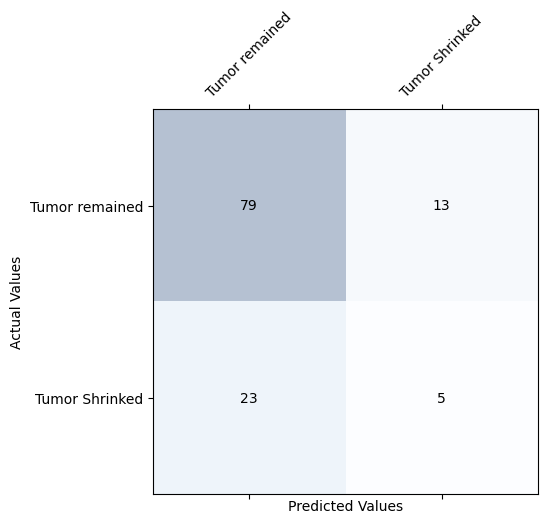

In [25]:
rf= RandomForestClassifier(**f_rf_search.best_params_)

rf.fit(X_train, y_train)
print(accuracy_score(y_train, rf.predict(X_train)))
y_pred =rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matriX
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["Tumor remained","Tumor Shrinked"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

### Cross validation

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

models = []
models.append(("Random Forest", rf))

# Test options and evaluation metric
num_folds = 5
num_instances = len(X_train)
scoring = "accuracy"
results = []
names = []

for name, model in models:
    kf = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    
print("5-Fold cross-validation accuracy score for the training data for all the classifiers")

for name, cv_results in zip(names, results):
    print("%-10s: %.6f (%.6f)" % (name, cv_results.mean(), cv_results.std()))

5-Fold cross-validation accuracy score for the training data for all the classifiers
Random Forest: 0.754351 (0.030514)


### ROC Curve

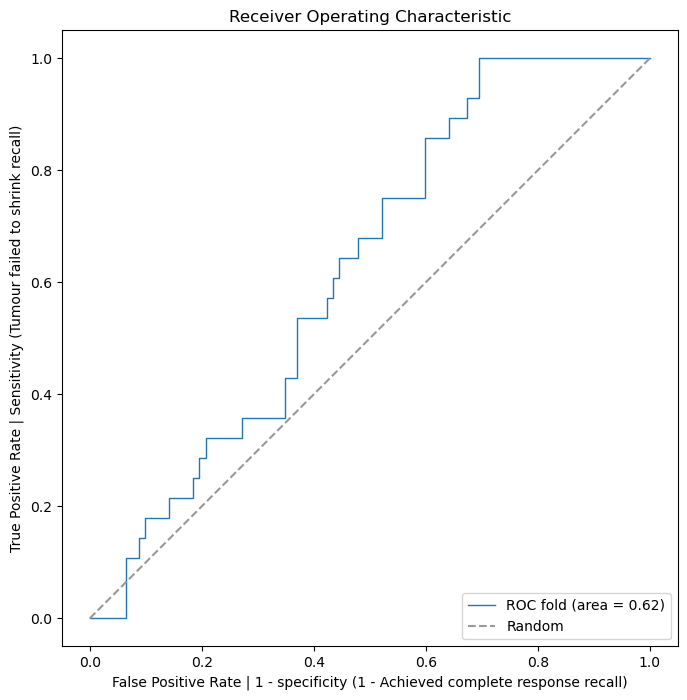

In [27]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10,8))
probas_ = rf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC fold (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate | 1 - specificity (1 - Achieved complete response recall)')
plt.ylabel('True Positive Rate | Sensitivity (Tumour failed to shrink recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.axes().set_aspect(1);